In [ ]:
!pip install sktime
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=708f12131847abdfd6f74bb7621a6348e4374e3c5a9640e7a65f1f0143425a8c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Fetch Data from MongoDB

In [ ]:
import pandas as pd
from pymongo import MongoClient
from tqdm import tqdm

def fetch_data_in_batches_with_progress(mongo_uri, db_name, collection_name, username, password, batch_size=100000):
    # Format the MongoDB URI with the provided username and password
    mongo_uri = f"mongodb://{username}:{password}@{mongo_uri}"
    client = MongoClient(mongo_uri)
    db = client[db_name]
    collection = db[collection_name]

    # Determine the total number of documents to set up the progress bar
    total_documents = collection.count_documents({})

    # Initialize the progress bar
    pbar = tqdm(total=total_documents, desc='Fetching Data', unit='doc')

    data_batches = []  # Store data in batches
    for skip in range(0, total_documents, batch_size):
        # Use skip and limit to fetch the batch
        cursor = collection.find().skip(skip).limit(batch_size)
        batch = list(cursor)

        # Convert the batch to a DataFrame and add it to the list
        batch_df = pd.DataFrame(batch)
        data_batches.append(batch_df)

        # Update the progress bar
        pbar.update(len(batch))

    # Combine all batches into a single DataFrame
    combined_df = pd.concat(data_batches, ignore_index=True)

    # Close the progress bar and clean up
    pbar.close()
    cursor.close()
    client.close()

    return combined_df

# Use this function to fetch data with progress tracking
data = fetch_data_in_batches_with_progress('mongodb:27017', 'Epsymolo', 'power_flow_all_data', 'root', 'root')

Training model

In [ ]:
import random
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, min, max, hour, avg
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [ ]:
spark = SparkSession.builder.appName("AnomalyDetectionBatchProcessing").getOrCreate()

In [ ]:
df = spark.read.csv(data, header=True)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

df = df.withColumn("Timestamp", F.to_timestamp("Timestamp"))

# Add a column for the ISO week of the year and year
df = df.withColumn("Year", F.year("Timestamp"))
df = df.withColumn("WeekOfYear", F.weekofyear("Timestamp"))

# Group by PowerLineID, Year, and WeekOfYear, then calculate the average power flow value for each week
weekly_avg_df = df.groupBy("PowerLineID", "Year", "WeekOfYear") \
                 .agg(F.avg("PowerFlowValue").alias("WeeklyAveragePowerFlow"))

In [ ]:
weekly_avg_df.show()

In [ ]:
type(weekly_avg_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
weekly_avg_df_pd = weekly_avg_df.toPandas()

In [ ]:
type(weekly_avg_df_pd)

pandas.core.frame.DataFrame

In [ ]:
weekly_avg_df_pd.head()

,PowerLineID,Year,WeekOfYear,WeeklyAveragePowerFlow
0,545,2010,26,25.771545
1,395,2010,26,-598.347797
2,1840,2010,26,-43.929075
3,888,2010,26,-80.168037
4,655,2010,26,115.804802


In [ ]:
features = ['PowerLineID', 'WeekOfYear', 'WeeklyAveragePowerFlow']
model = IsolationForest(random_state = 0, contamination = float(0.09))
model.fit(weekly_avg_df_pd[features])

IsolationForest(contamination=0.09, random_state=0)

In [ ]:
features = ['PowerLineID', 'WeekOfYear', 'WeeklyAveragePowerFlow']
weekly_avg_df_pd['score'] = model.decision_function(weekly_avg_df_pd[features])
weekly_avg_df_pd['anomaly_value'] = model.predict(weekly_avg_df_pd[features])
weekly_avg_df_pd.head()

,PowerLineID,Year,WeekOfYear,WeeklyAveragePowerFlow,score,anomaly_value
0,545,2010,26,25.771545,0.105964,1
1,395,2010,26,-598.347797,-0.056914,-1
2,1840,2010,26,-43.929075,0.043206,1
3,888,2010,26,-80.168037,0.085001,1
4,655,2010,26,115.804802,0.061934,1


 1    6974
-1     690
Name: anomaly_value, dtype: int64


<Axes: >

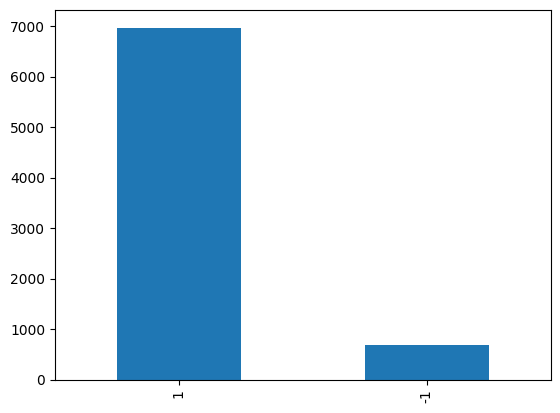

In [ ]:
outliers = weekly_avg_df_pd.loc[weekly_avg_df_pd['anomaly_value'] == -1]
outlier_index = list(outliers.index)

#datapoints classified -1 are anomalous
print(weekly_avg_df_pd['anomaly_value'].value_counts())
weekly_avg_df_pd['anomaly_value'].value_counts().plot(kind = 'bar')

In [ ]:
from joblib import dump

In [ ]:
dump(model,"Iforest.joblib")

['Iforest.joblib']

In [ ]:
import sklearn
print(sklearn.__version__)

1.3.1


Prediction on static data point

In [ ]:
single_row = {'Timestamp': 1702944366554,
              'DayOfWeek': 'Friday',
              'PowerLineID': 1219.0,
              'PowerFlowValue': 36.59}

In [ ]:
#Trying that on a one row:
row = spark.createDataFrame([single_row])

In [ ]:
row.show()

+---------+--------------+-----------+-------------+
|DayOfWeek|PowerFlowValue|PowerLineID|    Timestamp|
+---------+--------------+-----------+-------------+
|   Friday|         36.59|     1219.0|1702944366554|
+---------+--------------+-----------+-------------+



In [ ]:
row = row.withColumn("Timestamp", F.to_timestamp("Timestamp"))

# Filter data to only include dates from July to September
#df = df.filter((F.month("Timestamp") >= 7) & (F.month("Timestamp") <= 9))

# Add a column for the ISO week of the year and year
row = row.withColumn("Year", F.year("Timestamp"))
row = row.withColumn("WeekOfYear", F.weekofyear("Timestamp"))

# Group by PowerLineID, Year, and WeekOfYear, then calculate the average power flow value for each week
weekly_avg_row = row.groupBy("PowerLineID", "Year", "WeekOfYear") \
                 .agg(F.avg("PowerFlowValue").alias("WeeklyAveragePowerFlow"))

In [ ]:
weekly_avg_row.show()

+-----------+-----+----------+----------------------+
|PowerLineID| Year|WeekOfYear|WeeklyAveragePowerFlow|
+-----------+-----+----------+----------------------+
|     1219.0|55934|         9|                 36.59|
+-----------+-----+----------+----------------------+



In [ ]:
weekly_avg_row =weekly_avg_row.toPandas()

In [ ]:
pip install scikit-learn==1.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
features = ['PowerLineID', 'Year', 'WeekOfYear', 'WeeklyAveragePowerFlow']
weekly_avg_row['score'] = model.decision_function(weekly_avg_row[features])
weekly_avg_row['anomaly_value'] = model.predict(weekly_avg_row[features])

In [ ]:
weekly_avg_row.head()

,PowerLineID,Year,WeekOfYear,WeeklyAveragePowerFlow,score,anomaly_value
0,1219.0,55934,9,36.59,0.134263,1
